[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-external-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239440-lesson-6-chatbot-w-summarizing-messages-and-external-memory)

# Chatbot with message summarization & external DB memory

## Review

We've covered how to customize graph state schema and reducer. 
 
We've also shown a number of tricks for trimming or filtering messages in graph state. 

We've used these concepts in a Chatbot with memory that produces a running summary of the conversation.

## Goals

But, what if we want our Chatbot to have memory that persists indefinitely?

Now, we'll introduce some more advanced checkpointers that support external databases. 

Here, we'll show how to use [Sqlite as a checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer), but other checkpointers, such as [Postgres](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/) are available!

In [5]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_openai

In [1]:
import os, getpass, sys
from langchain_anthropic import ChatAnthropic

#Import API Keys(storing them all in a seperate file so i run into less issues with git)
_root = "/home/zjc1002/Mounts/code/"
_langsmith_trace = 'true'
_langsmith_project = 'zjc_custom_v1'
_anthropic_model = 'claude-3-haiku-20240307'
_temparate = 0
_max_tokens = 4000
_streaming = True
_system_message = None
_db_path = "/home/zjc1002/Mounts/data/langgraph_memory/state_db/example1.db"
# This is a basic config to enable tracing of conversations and  utilization of memory
_config = {'configurable': {'thread_id':"1"}}

# Custom functions
sys.path.append(_root)
from  admin.api_keys import _api_keys
from admin.sys_ops import _set_env
from langgraph_projects.tools import get_weather, get_date, multiply, add, divide

# This anthropic and internet tool requires  API key to be set as a environment variable(s)
for api_key in ["TAVILY_API_KEY","ANTHROPIC_API_KEY",'OPENAI_API_KEY','LANGSMITH_API_KEY']:
    _set_env(api_key
            ,value =  _api_keys[api_key])

## Sqlite

A good starting point here is the [SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer).

Sqlite is a [small, fast, highly popular](https://x.com/karpathy/status/1819490455664685297) SQL database. 
 
If we supply `":memory:"` it creates an in-memory Sqlite database.

In [ ]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

But, if we supply a db path, then it will create a database for us!

In [3]:
# pull file if it doesn't exist and connect to local db
#!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db
#db_path = "state_db/example.db"
conn = sqlite3.connect(_db_path, check_same_thread=False)

In [4]:
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

Let's re-define our chatbot.

In [5]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState
from typing import Dict, Literal, Optional

# Define LLM with bound tools
model = ChatAnthropic(
    model=_anthropic_model,
    temperature=_temparate,
    max_tokens=_max_tokens,
    streaming=_streaming,
    verbose=True,
)


class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State)-> Dict[str, str]:
    """check if summary exists and add it to the system message
    and append it to the messages. Then call the model with the messages.
    or if no summary exists, just call the model with the messages.

    Args:
        state (State):  this is the state of the conversation

    Returns:
        Dict[str, str]:  this is the response from the model
    """

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State)-> Literal["summarize_conversation", "__end__"]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return "__end__"

Now, we just re-compile with our sqlite checkpointer.

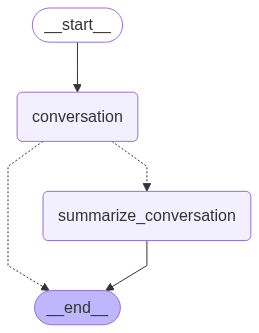

In [6]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation"
                               , should_continue
                               , {
                                   "summarize_conversation": "summarize_conversation",
                                   "__end__": END
                               })
                               
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Now, we can invoke the graph several times. 

In [7]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Okay, got it - your name is Lance. It's nice to meet you again, Lance! I'm always happy to chat about sports or any other topics you're interested in. What do you enjoy most about being a 49ers fan?
================================== Ai Message ==================================

Your name is Lance. That's what you introduced yourself as at the beginning of our conversation.
================================== Ai Message ==================================

Ah yes, you mentioned earlier that you are a fan of the 49ers. That's great! The 49ers have a rich history and passionate fanbase. What do you enjoy most about following the team? Do you have a favorite player or memorable moment as a 49ers fan?


Let's confirm that our state is saved locally.

In [8]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)


graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='05779117-169b-4726-adc4-e31981ccb08f'), AIMessage(content="Okay, got it - your name is Lance. It's nice to meet you again, Lance! I'm always happy to chat about sports or any other topics you're interested in. What do you enjoy most about being a 49ers fan?", additional_kwargs={}, response_metadata={'model_name': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None}, id='run--5b617221-3176-4ed5-b5da-a8405d2b4a22-0', usage_metadata={'input_tokens': 154, 'output_tokens': 60, 'total_tokens': 214, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}}), HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='2f508d4b-0516-495c-ad6f-eb568b5a58bd'), AIMessage(content="Your name is Lance. That's what you introduced yourself as at the beginning of our conversation.", additional_kwargs={}, response_metadata={'mode

### Persisting state

Using database like Sqlite means state is persisted! 

For example, we can re-start the notebook kernel and see that we can still load from Sqlite DB on disk.


In [9]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
list(graph_state)


[{'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='05779117-169b-4726-adc4-e31981ccb08f'),
   AIMessage(content="Okay, got it - your name is Lance. It's nice to meet you again, Lance! I'm always happy to chat about sports or any other topics you're interested in. What do you enjoy most about being a 49ers fan?", additional_kwargs={}, response_metadata={'model_name': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None}, id='run--5b617221-3176-4ed5-b5da-a8405d2b4a22-0', usage_metadata={'input_tokens': 154, 'output_tokens': 60, 'total_tokens': 214, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}}),
   HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='2f508d4b-0516-495c-ad6f-eb568b5a58bd'),
   AIMessage(content="Your name is Lance. That's what you introduced yourself as at the beginning of our conversation.", additional_kwargs={}, response_metadata={'model_name': 'c

## LangGraph Studio

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.